# Object detection with Keras and TS

- Documentation : https://www.tensorflow.org/hub/tutorials/object_detection?hl=fr

## Setup

In [1]:
%pip install -q tflite-model-maker
%pip install -q tflite-support
%pip install opencv-python-headless==4.5.2.52
!pip3 install pycocotools



try:
# pylint: disable=g-import-not-at-top
  from pycocotools.coco import COCO
  from pycocotools.cocoeval import COCOeval
# pylint: enable=g-import-not-at-top
except ImportError:
  print('Erreur')


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import os

from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

2024-04-12 22:03:36.448202: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-12 22:03:36.448243: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/charles/web/alyra/villepropre/vp-server/.venv/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/home/charles/web/alyra/villepropre/vp-server/.venv/lib

## Chargement du jeu de données

In [3]:
train_folder = 'datasets/dataset.voc/train'
val_folder = 'datasets/dataset.voc/valid'
test_folder = 'datasets/dataset.voc/test'

# These images are used to train the object detection model to recognize plastic and can
train_data = object_detector.DataLoader.from_pascal_voc(
    train_folder,
    train_folder,
    ['plastique','canette']
)

# These images are used to evaluate the model. 
# These are images that the model didn't see during the training process. You'll use them to decide when you should stop the training, to avoid overfitting.
val_data = object_detector.DataLoader.from_pascal_voc(
    val_folder,
    val_folder,
    # label_map={1: "plastique", 2: "canette"}
    ['plastique','canette']
)

# These images are used to evaluate the final model performance.
test_data = object_detector.DataLoader.from_pascal_voc(
    test_folder,
    test_folder,
    ['plastique','canette']
)

## Mise en cache des données

In [4]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

## Selection du modèle

In [5]:
# Liste des modèles possibles : https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/model_spec
# spec = model_spec.get('mobilenet_v2')
# spec = model_spec.get('efficientdet_lite4')

verbose=1
tflite_max_detections=2

spec = model_spec.get('efficientdet_lite3')
spec.tflite_max_detections=tflite_max_detections
spec.verbose=verbose


2024-04-12 22:03:49.823179: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-04-12 22:03:49.823243: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-04-12 22:03:49.823265: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-R17EPGM): /proc/driver/nvidia/version does not exist
2024-04-12 22:03:49.827324: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Entrainement du modèle

In [6]:
# Entraîner entièrement le modèle (fine-tuning) ?
train_whole_model=True
epochs=80
batch_size=5
model = object_detector.create(train_data, 
                               validation_data=val_data,
                               model_spec=spec, 
                               train_whole_model=train_whole_model,
                               epochs=epochs,
                               batch_size=batch_size
                               )


Epoch 1/80


2024-04-12 22:04:08.205114: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - ETA: 0s - det_loss: 1.6667 - cls_loss: 1.0991 - box_loss: 0.0114 - reg_l2_loss: 0.0926 - loss: 1.7593 - learning_rate: 0.0072 - gradient_norm: 1.3022

2024-04-12 22:06:45.957211: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 170s 6s/step - det_loss: 1.6584 - cls_loss: 1.0939 - box_loss: 0.0113 - reg_l2_loss: 0.0926 - loss: 1.7509 - learning_rate: 0.0071 - gradient_norm: 1.3240 - val_det_loss: 1.2946 - val_cls_loss: 0.8964 - val_box_loss: 0.0080 - val_reg_l2_loss: 0.0926 - val_loss: 1.3872
Epoch 2/80
21/21 [==============================] - ETA: 0s - det_loss: 1.2925 - cls_loss: 0.8491 - box_loss: 0.0089 - reg_l2_loss: 0.0926 - loss: 1.3851 - learning_rate: 0.0062 - gradient_norm: 2.7992

2024-04-12 22:09:06.426111: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 137s 7s/step - det_loss: 1.2895 - cls_loss: 0.8455 - box_loss: 0.0089 - reg_l2_loss: 0.0926 - loss: 1.3821 - learning_rate: 0.0062 - gradient_norm: 2.8689 - val_det_loss: 1.0214 - val_cls_loss: 0.7119 - val_box_loss: 0.0062 - val_reg_l2_loss: 0.0926 - val_loss: 1.1140
Epoch 3/80
21/21 [==============================] - ETA: 0s - det_loss: 0.9679 - cls_loss: 0.6047 - box_loss: 0.0073 - reg_l2_loss: 0.0926 - loss: 1.0605 - learning_rate: 0.0062 - gradient_norm: 3.6378

2024-04-12 22:11:17.875956: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 129s 6s/step - det_loss: 0.9556 - cls_loss: 0.5983 - box_loss: 0.0071 - reg_l2_loss: 0.0926 - loss: 1.0482 - learning_rate: 0.0062 - gradient_norm: 3.5611 - val_det_loss: 0.9694 - val_cls_loss: 0.6274 - val_box_loss: 0.0068 - val_reg_l2_loss: 0.0926 - val_loss: 1.0620
Epoch 4/80
21/21 [==============================] - ETA: 0s - det_loss: 0.7944 - cls_loss: 0.4804 - box_loss: 0.0063 - reg_l2_loss: 0.0926 - loss: 0.8870 - learning_rate: 0.0062 - gradient_norm: 3.7692

2024-04-12 22:13:08.403983: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 111s 5s/step - det_loss: 0.7871 - cls_loss: 0.4755 - box_loss: 0.0062 - reg_l2_loss: 0.0926 - loss: 0.8797 - learning_rate: 0.0062 - gradient_norm: 3.7270 - val_det_loss: 0.8111 - val_cls_loss: 0.4969 - val_box_loss: 0.0063 - val_reg_l2_loss: 0.0926 - val_loss: 0.9038
Epoch 5/80
21/21 [==============================] - ETA: 0s - det_loss: 0.7477 - cls_loss: 0.4638 - box_loss: 0.0057 - reg_l2_loss: 0.0926 - loss: 0.8403 - learning_rate: 0.0062 - gradient_norm: 4.3624

2024-04-12 22:15:06.117670: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 128s 6s/step - det_loss: 0.7499 - cls_loss: 0.4673 - box_loss: 0.0057 - reg_l2_loss: 0.0926 - loss: 0.8426 - learning_rate: 0.0062 - gradient_norm: 4.3736 - val_det_loss: 0.8181 - val_cls_loss: 0.4911 - val_box_loss: 0.0065 - val_reg_l2_loss: 0.0927 - val_loss: 0.9108
Epoch 6/80
21/21 [==============================] - ETA: 0s - det_loss: 0.6971 - cls_loss: 0.4165 - box_loss: 0.0056 - reg_l2_loss: 0.0927 - loss: 0.7898 - learning_rate: 0.0062 - gradient_norm: 4.7438

2024-04-12 22:17:10.580027: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 114s 5s/step - det_loss: 0.6892 - cls_loss: 0.4109 - box_loss: 0.0056 - reg_l2_loss: 0.0927 - loss: 0.7819 - learning_rate: 0.0062 - gradient_norm: 4.6506 - val_det_loss: 0.6862 - val_cls_loss: 0.4317 - val_box_loss: 0.0051 - val_reg_l2_loss: 0.0927 - val_loss: 0.7789
Epoch 7/80
21/21 [==============================] - ETA: 0s - det_loss: 0.6016 - cls_loss: 0.3721 - box_loss: 0.0046 - reg_l2_loss: 0.0927 - loss: 0.6944 - learning_rate: 0.0061 - gradient_norm: 4.3303

2024-04-12 22:19:07.568361: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 117s 6s/step - det_loss: 0.6009 - cls_loss: 0.3714 - box_loss: 0.0046 - reg_l2_loss: 0.0927 - loss: 0.6936 - learning_rate: 0.0061 - gradient_norm: 4.2893 - val_det_loss: 0.6661 - val_cls_loss: 0.4094 - val_box_loss: 0.0051 - val_reg_l2_loss: 0.0927 - val_loss: 0.7588
Epoch 8/80
21/21 [==============================] - ETA: 0s - det_loss: 0.5259 - cls_loss: 0.3319 - box_loss: 0.0039 - reg_l2_loss: 0.0927 - loss: 0.6186 - learning_rate: 0.0061 - gradient_norm: 3.5839

2024-04-12 22:20:59.058399: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 113s 5s/step - det_loss: 0.5229 - cls_loss: 0.3300 - box_loss: 0.0039 - reg_l2_loss: 0.0927 - loss: 0.6156 - learning_rate: 0.0061 - gradient_norm: 3.5577 - val_det_loss: 0.6803 - val_cls_loss: 0.4250 - val_box_loss: 0.0051 - val_reg_l2_loss: 0.0927 - val_loss: 0.7730
Epoch 9/80
21/21 [==============================] - ETA: 0s - det_loss: 0.5005 - cls_loss: 0.3170 - box_loss: 0.0037 - reg_l2_loss: 0.0928 - loss: 0.5933 - learning_rate: 0.0061 - gradient_norm: 3.9447

2024-04-12 22:22:52.454518: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 112s 5s/step - det_loss: 0.5047 - cls_loss: 0.3194 - box_loss: 0.0037 - reg_l2_loss: 0.0928 - loss: 0.5974 - learning_rate: 0.0061 - gradient_norm: 4.0610 - val_det_loss: 0.6519 - val_cls_loss: 0.4189 - val_box_loss: 0.0047 - val_reg_l2_loss: 0.0928 - val_loss: 0.7447
Epoch 10/80
21/21 [==============================] - ETA: 0s - det_loss: 0.4662 - cls_loss: 0.2973 - box_loss: 0.0034 - reg_l2_loss: 0.0928 - loss: 0.5590 - learning_rate: 0.0060 - gradient_norm: 3.5987

2024-04-12 22:24:53.838523: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 127s 6s/step - det_loss: 0.4623 - cls_loss: 0.2941 - box_loss: 0.0034 - reg_l2_loss: 0.0928 - loss: 0.5550 - learning_rate: 0.0060 - gradient_norm: 3.5106 - val_det_loss: 0.5728 - val_cls_loss: 0.3514 - val_box_loss: 0.0044 - val_reg_l2_loss: 0.0928 - val_loss: 0.6656
Epoch 11/80
21/21 [==============================] - ETA: 0s - det_loss: 0.4509 - cls_loss: 0.2900 - box_loss: 0.0032 - reg_l2_loss: 0.0928 - loss: 0.5437 - learning_rate: 0.0060 - gradient_norm: 4.2123

2024-04-12 22:27:06.584465: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 128s 6s/step - det_loss: 0.4529 - cls_loss: 0.2917 - box_loss: 0.0032 - reg_l2_loss: 0.0928 - loss: 0.5457 - learning_rate: 0.0060 - gradient_norm: 4.2048 - val_det_loss: 0.5553 - val_cls_loss: 0.3150 - val_box_loss: 0.0048 - val_reg_l2_loss: 0.0928 - val_loss: 0.6481
Epoch 12/80
21/21 [==============================] - ETA: 0s - det_loss: 0.4627 - cls_loss: 0.2916 - box_loss: 0.0034 - reg_l2_loss: 0.0928 - loss: 0.5555 - learning_rate: 0.0059 - gradient_norm: 4.2088

2024-04-12 22:29:00.934430: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 113s 5s/step - det_loss: 0.4587 - cls_loss: 0.2878 - box_loss: 0.0034 - reg_l2_loss: 0.0928 - loss: 0.5515 - learning_rate: 0.0059 - gradient_norm: 4.1606 - val_det_loss: 0.6170 - val_cls_loss: 0.3212 - val_box_loss: 0.0059 - val_reg_l2_loss: 0.0928 - val_loss: 0.7098
Epoch 13/80
21/21 [==============================] - ETA: 0s - det_loss: 0.4209 - cls_loss: 0.2631 - box_loss: 0.0032 - reg_l2_loss: 0.0928 - loss: 0.5137 - learning_rate: 0.0059 - gradient_norm: 3.6852

2024-04-12 22:30:52.456422: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 116s 6s/step - det_loss: 0.4272 - cls_loss: 0.2678 - box_loss: 0.0032 - reg_l2_loss: 0.0928 - loss: 0.5200 - learning_rate: 0.0059 - gradient_norm: 3.8325 - val_det_loss: 0.5733 - val_cls_loss: 0.3519 - val_box_loss: 0.0044 - val_reg_l2_loss: 0.0928 - val_loss: 0.6662
Epoch 14/80
21/21 [==============================] - ETA: 0s - det_loss: 0.4316 - cls_loss: 0.2726 - box_loss: 0.0032 - reg_l2_loss: 0.0928 - loss: 0.5245 - learning_rate: 0.0058 - gradient_norm: 4.5301

2024-04-12 22:32:47.801611: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 112s 5s/step - det_loss: 0.4307 - cls_loss: 0.2713 - box_loss: 0.0032 - reg_l2_loss: 0.0928 - loss: 0.5236 - learning_rate: 0.0058 - gradient_norm: 4.4935 - val_det_loss: 0.6602 - val_cls_loss: 0.4096 - val_box_loss: 0.0050 - val_reg_l2_loss: 0.0929 - val_loss: 0.7531
Epoch 15/80
21/21 [==============================] - ETA: 0s - det_loss: 0.4279 - cls_loss: 0.2629 - box_loss: 0.0033 - reg_l2_loss: 0.0929 - loss: 0.5207 - learning_rate: 0.0057 - gradient_norm: 3.9601

2024-04-12 22:34:40.499449: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 121s 6s/step - det_loss: 0.4260 - cls_loss: 0.2616 - box_loss: 0.0033 - reg_l2_loss: 0.0929 - loss: 0.5188 - learning_rate: 0.0057 - gradient_norm: 3.9155 - val_det_loss: 0.8970 - val_cls_loss: 0.4735 - val_box_loss: 0.0085 - val_reg_l2_loss: 0.0929 - val_loss: 0.9899
Epoch 16/80
21/21 [==============================] - ETA: 0s - det_loss: 0.4291 - cls_loss: 0.2540 - box_loss: 0.0035 - reg_l2_loss: 0.0929 - loss: 0.5220 - learning_rate: 0.0057 - gradient_norm: 3.9070

2024-04-12 22:36:39.810998: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 110s 5s/step - det_loss: 0.4331 - cls_loss: 0.2593 - box_loss: 0.0035 - reg_l2_loss: 0.0929 - loss: 0.5260 - learning_rate: 0.0057 - gradient_norm: 3.9849 - val_det_loss: 0.7647 - val_cls_loss: 0.4260 - val_box_loss: 0.0068 - val_reg_l2_loss: 0.0929 - val_loss: 0.8576
Epoch 17/80
21/21 [==============================] - ETA: 0s - det_loss: 0.3634 - cls_loss: 0.2284 - box_loss: 0.0027 - reg_l2_loss: 0.0929 - loss: 0.4563 - learning_rate: 0.0056 - gradient_norm: 3.3568

2024-04-12 22:38:27.623466: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 108s 5s/step - det_loss: 0.3648 - cls_loss: 0.2290 - box_loss: 0.0027 - reg_l2_loss: 0.0929 - loss: 0.4577 - learning_rate: 0.0056 - gradient_norm: 3.5530 - val_det_loss: 0.6834 - val_cls_loss: 0.3991 - val_box_loss: 0.0057 - val_reg_l2_loss: 0.0929 - val_loss: 0.7763
Epoch 18/80
21/21 [==============================] - ETA: 0s - det_loss: 0.4020 - cls_loss: 0.2346 - box_loss: 0.0033 - reg_l2_loss: 0.0929 - loss: 0.4949 - learning_rate: 0.0055 - gradient_norm: 4.1209

2024-04-12 22:40:20.010708: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 114s 5s/step - det_loss: 0.4028 - cls_loss: 0.2360 - box_loss: 0.0033 - reg_l2_loss: 0.0929 - loss: 0.4957 - learning_rate: 0.0055 - gradient_norm: 4.1112 - val_det_loss: 0.6882 - val_cls_loss: 0.4052 - val_box_loss: 0.0057 - val_reg_l2_loss: 0.0929 - val_loss: 0.7811
Epoch 19/80
21/21 [==============================] - ETA: 0s - det_loss: 0.4088 - cls_loss: 0.2613 - box_loss: 0.0029 - reg_l2_loss: 0.0929 - loss: 0.5017 - learning_rate: 0.0054 - gradient_norm: 4.7740

2024-04-12 22:42:18.547511: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 117s 6s/step - det_loss: 0.4095 - cls_loss: 0.2602 - box_loss: 0.0030 - reg_l2_loss: 0.0929 - loss: 0.5025 - learning_rate: 0.0054 - gradient_norm: 4.7155 - val_det_loss: 0.8092 - val_cls_loss: 0.4936 - val_box_loss: 0.0063 - val_reg_l2_loss: 0.0929 - val_loss: 0.9021
Epoch 20/80
21/21 [==============================] - ETA: 0s - det_loss: 0.4127 - cls_loss: 0.2672 - box_loss: 0.0029 - reg_l2_loss: 0.0930 - loss: 0.5057 - learning_rate: 0.0054 - gradient_norm: 4.4389

2024-04-12 22:44:05.433226: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 114s 5s/step - det_loss: 0.4115 - cls_loss: 0.2669 - box_loss: 0.0029 - reg_l2_loss: 0.0930 - loss: 0.5044 - learning_rate: 0.0054 - gradient_norm: 4.3843 - val_det_loss: 0.7804 - val_cls_loss: 0.4952 - val_box_loss: 0.0057 - val_reg_l2_loss: 0.0930 - val_loss: 0.8733
Epoch 21/80
21/21 [==============================] - ETA: 0s - det_loss: 0.3535 - cls_loss: 0.2219 - box_loss: 0.0026 - reg_l2_loss: 0.0930 - loss: 0.4464 - learning_rate: 0.0053 - gradient_norm: 3.6913

2024-04-12 22:46:05.511336: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 114s 5s/step - det_loss: 0.3522 - cls_loss: 0.2211 - box_loss: 0.0026 - reg_l2_loss: 0.0930 - loss: 0.4452 - learning_rate: 0.0053 - gradient_norm: 3.6348 - val_det_loss: 0.6342 - val_cls_loss: 0.3360 - val_box_loss: 0.0060 - val_reg_l2_loss: 0.0930 - val_loss: 0.7272
Epoch 22/80
21/21 [==============================] - ETA: 0s - det_loss: 0.3361 - cls_loss: 0.2093 - box_loss: 0.0025 - reg_l2_loss: 0.0930 - loss: 0.4291 - learning_rate: 0.0052 - gradient_norm: 3.2630

2024-04-12 22:47:53.288182: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 107s 5s/step - det_loss: 0.3369 - cls_loss: 0.2089 - box_loss: 0.0026 - reg_l2_loss: 0.0930 - loss: 0.4299 - learning_rate: 0.0052 - gradient_norm: 3.2161 - val_det_loss: 0.4805 - val_cls_loss: 0.2724 - val_box_loss: 0.0042 - val_reg_l2_loss: 0.0930 - val_loss: 0.5735
Epoch 23/80
21/21 [==============================] - ETA: 0s - det_loss: 0.3597 - cls_loss: 0.2208 - box_loss: 0.0028 - reg_l2_loss: 0.0930 - loss: 0.4527 - learning_rate: 0.0051 - gradient_norm: 3.0069

2024-04-12 22:49:43.326769: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 110s 5s/step - det_loss: 0.3579 - cls_loss: 0.2217 - box_loss: 0.0027 - reg_l2_loss: 0.0930 - loss: 0.4509 - learning_rate: 0.0051 - gradient_norm: 2.9853 - val_det_loss: 0.5878 - val_cls_loss: 0.3424 - val_box_loss: 0.0049 - val_reg_l2_loss: 0.0930 - val_loss: 0.6808
Epoch 24/80
21/21 [==============================] - ETA: 0s - det_loss: 0.3348 - cls_loss: 0.2099 - box_loss: 0.0025 - reg_l2_loss: 0.0930 - loss: 0.4278 - learning_rate: 0.0050 - gradient_norm: 3.1631

2024-04-12 22:51:36.913500: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 114s 5s/step - det_loss: 0.3350 - cls_loss: 0.2092 - box_loss: 0.0025 - reg_l2_loss: 0.0930 - loss: 0.4280 - learning_rate: 0.0050 - gradient_norm: 3.1177 - val_det_loss: 0.5894 - val_cls_loss: 0.3736 - val_box_loss: 0.0043 - val_reg_l2_loss: 0.0930 - val_loss: 0.6824
Epoch 25/80
21/21 [==============================] - ETA: 0s - det_loss: 0.3390 - cls_loss: 0.2106 - box_loss: 0.0026 - reg_l2_loss: 0.0930 - loss: 0.4320 - learning_rate: 0.0049 - gradient_norm: 3.2744

2024-04-12 22:53:25.301318: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 115s 6s/step - det_loss: 0.3379 - cls_loss: 0.2105 - box_loss: 0.0025 - reg_l2_loss: 0.0930 - loss: 0.4309 - learning_rate: 0.0049 - gradient_norm: 3.3472 - val_det_loss: 0.6492 - val_cls_loss: 0.3938 - val_box_loss: 0.0051 - val_reg_l2_loss: 0.0930 - val_loss: 0.7422
Epoch 26/80
21/21 [==============================] - ETA: 0s - det_loss: 0.3469 - cls_loss: 0.2124 - box_loss: 0.0027 - reg_l2_loss: 0.0930 - loss: 0.4399 - learning_rate: 0.0048 - gradient_norm: 3.4881

2024-04-12 22:55:29.889080: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 118s 6s/step - det_loss: 0.3464 - cls_loss: 0.2115 - box_loss: 0.0027 - reg_l2_loss: 0.0930 - loss: 0.4394 - learning_rate: 0.0048 - gradient_norm: 3.4422 - val_det_loss: 0.7196 - val_cls_loss: 0.4418 - val_box_loss: 0.0056 - val_reg_l2_loss: 0.0930 - val_loss: 0.8126
Epoch 27/80
21/21 [==============================] - ETA: 0s - det_loss: 0.3391 - cls_loss: 0.2152 - box_loss: 0.0025 - reg_l2_loss: 0.0930 - loss: 0.4321 - learning_rate: 0.0047 - gradient_norm: 3.5740

2024-04-12 22:57:23.104662: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 113s 5s/step - det_loss: 0.3375 - cls_loss: 0.2138 - box_loss: 0.0025 - reg_l2_loss: 0.0930 - loss: 0.4306 - learning_rate: 0.0047 - gradient_norm: 3.4898 - val_det_loss: 0.6533 - val_cls_loss: 0.3971 - val_box_loss: 0.0051 - val_reg_l2_loss: 0.0930 - val_loss: 0.7463
Epoch 28/80
21/21 [==============================] - ETA: 0s - det_loss: 0.3478 - cls_loss: 0.2205 - box_loss: 0.0025 - reg_l2_loss: 0.0930 - loss: 0.4408 - learning_rate: 0.0046 - gradient_norm: 4.0624

2024-04-12 22:59:22.265734: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 121s 6s/step - det_loss: 0.3455 - cls_loss: 0.2196 - box_loss: 0.0025 - reg_l2_loss: 0.0930 - loss: 0.4385 - learning_rate: 0.0046 - gradient_norm: 4.1103 - val_det_loss: 0.6992 - val_cls_loss: 0.4587 - val_box_loss: 0.0048 - val_reg_l2_loss: 0.0930 - val_loss: 0.7923
Epoch 29/80
21/21 [==============================] - ETA: 0s - det_loss: 0.3282 - cls_loss: 0.2146 - box_loss: 0.0023 - reg_l2_loss: 0.0930 - loss: 0.4212 - learning_rate: 0.0045 - gradient_norm: 3.7145

2024-04-12 23:01:26.741538: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 123s 6s/step - det_loss: 0.3276 - cls_loss: 0.2137 - box_loss: 0.0023 - reg_l2_loss: 0.0930 - loss: 0.4207 - learning_rate: 0.0044 - gradient_norm: 3.6899 - val_det_loss: 0.5946 - val_cls_loss: 0.3666 - val_box_loss: 0.0046 - val_reg_l2_loss: 0.0930 - val_loss: 0.6877
Epoch 30/80
21/21 [==============================] - ETA: 0s - det_loss: 0.3458 - cls_loss: 0.2179 - box_loss: 0.0026 - reg_l2_loss: 0.0931 - loss: 0.4389 - learning_rate: 0.0043 - gradient_norm: 3.5538

2024-04-12 23:03:32.242974: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 134s 6s/step - det_loss: 0.3418 - cls_loss: 0.2150 - box_loss: 0.0025 - reg_l2_loss: 0.0931 - loss: 0.4348 - learning_rate: 0.0043 - gradient_norm: 3.4830 - val_det_loss: 0.5576 - val_cls_loss: 0.3286 - val_box_loss: 0.0046 - val_reg_l2_loss: 0.0931 - val_loss: 0.6507
Epoch 31/80
21/21 [==============================] - ETA: 0s - det_loss: 0.3175 - cls_loss: 0.2015 - box_loss: 0.0023 - reg_l2_loss: 0.0931 - loss: 0.4106 - learning_rate: 0.0042 - gradient_norm: 3.6836

2024-04-12 23:05:38.352534: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 118s 6s/step - det_loss: 0.3198 - cls_loss: 0.2050 - box_loss: 0.0023 - reg_l2_loss: 0.0931 - loss: 0.4128 - learning_rate: 0.0042 - gradient_norm: 3.7702 - val_det_loss: 0.5548 - val_cls_loss: 0.3256 - val_box_loss: 0.0046 - val_reg_l2_loss: 0.0931 - val_loss: 0.6479
Epoch 32/80
21/21 [==============================] - ETA: 0s - det_loss: 0.3193 - cls_loss: 0.1984 - box_loss: 0.0024 - reg_l2_loss: 0.0931 - loss: 0.4124 - learning_rate: 0.0041 - gradient_norm: 3.8161

2024-04-12 23:07:34.596069: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 116s 6s/step - det_loss: 0.3185 - cls_loss: 0.1977 - box_loss: 0.0024 - reg_l2_loss: 0.0931 - loss: 0.4116 - learning_rate: 0.0041 - gradient_norm: 3.7293 - val_det_loss: 0.5839 - val_cls_loss: 0.3398 - val_box_loss: 0.0049 - val_reg_l2_loss: 0.0931 - val_loss: 0.6769
Epoch 33/80
21/21 [==============================] - ETA: 0s - det_loss: 0.3119 - cls_loss: 0.1992 - box_loss: 0.0023 - reg_l2_loss: 0.0931 - loss: 0.4050 - learning_rate: 0.0040 - gradient_norm: 3.9372

2024-04-12 23:09:30.131651: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 115s 6s/step - det_loss: 0.3090 - cls_loss: 0.1977 - box_loss: 0.0022 - reg_l2_loss: 0.0931 - loss: 0.4020 - learning_rate: 0.0040 - gradient_norm: 3.8697 - val_det_loss: 0.4981 - val_cls_loss: 0.2961 - val_box_loss: 0.0040 - val_reg_l2_loss: 0.0931 - val_loss: 0.5911
Epoch 34/80
21/21 [==============================] - ETA: 0s - det_loss: 0.3319 - cls_loss: 0.2152 - box_loss: 0.0023 - reg_l2_loss: 0.0931 - loss: 0.4249 - learning_rate: 0.0039 - gradient_norm: 2.9440

2024-04-12 23:11:23.926364: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 114s 5s/step - det_loss: 0.3315 - cls_loss: 0.2148 - box_loss: 0.0023 - reg_l2_loss: 0.0931 - loss: 0.4246 - learning_rate: 0.0039 - gradient_norm: 2.9586 - val_det_loss: 0.4761 - val_cls_loss: 0.2729 - val_box_loss: 0.0041 - val_reg_l2_loss: 0.0931 - val_loss: 0.5692
Epoch 35/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2745 - cls_loss: 0.1749 - box_loss: 0.0020 - reg_l2_loss: 0.0931 - loss: 0.3675 - learning_rate: 0.0037 - gradient_norm: 2.5562

2024-04-12 23:13:25.976308: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 131s 6s/step - det_loss: 0.2734 - cls_loss: 0.1741 - box_loss: 0.0020 - reg_l2_loss: 0.0931 - loss: 0.3664 - learning_rate: 0.0037 - gradient_norm: 2.5267 - val_det_loss: 0.4786 - val_cls_loss: 0.2850 - val_box_loss: 0.0039 - val_reg_l2_loss: 0.0931 - val_loss: 0.5717
Epoch 36/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2769 - cls_loss: 0.1779 - box_loss: 0.0020 - reg_l2_loss: 0.0931 - loss: 0.3700 - learning_rate: 0.0036 - gradient_norm: 2.6007

2024-04-12 23:15:41.194808: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 125s 6s/step - det_loss: 0.2808 - cls_loss: 0.1800 - box_loss: 0.0020 - reg_l2_loss: 0.0931 - loss: 0.3739 - learning_rate: 0.0036 - gradient_norm: 2.7147 - val_det_loss: 0.4406 - val_cls_loss: 0.2689 - val_box_loss: 0.0034 - val_reg_l2_loss: 0.0931 - val_loss: 0.5336
Epoch 37/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2933 - cls_loss: 0.1927 - box_loss: 0.0020 - reg_l2_loss: 0.0931 - loss: 0.3864 - learning_rate: 0.0035 - gradient_norm: 3.0587

2024-04-12 23:17:31.038638: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 110s 5s/step - det_loss: 0.2946 - cls_loss: 0.1929 - box_loss: 0.0020 - reg_l2_loss: 0.0931 - loss: 0.3877 - learning_rate: 0.0035 - gradient_norm: 3.0665 - val_det_loss: 0.5342 - val_cls_loss: 0.2900 - val_box_loss: 0.0049 - val_reg_l2_loss: 0.0931 - val_loss: 0.6273
Epoch 38/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2954 - cls_loss: 0.1856 - box_loss: 0.0022 - reg_l2_loss: 0.0931 - loss: 0.3884 - learning_rate: 0.0034 - gradient_norm: 3.0562

2024-04-12 23:19:20.930236: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 110s 5s/step - det_loss: 0.2938 - cls_loss: 0.1848 - box_loss: 0.0022 - reg_l2_loss: 0.0931 - loss: 0.3869 - learning_rate: 0.0034 - gradient_norm: 3.0125 - val_det_loss: 0.5809 - val_cls_loss: 0.3625 - val_box_loss: 0.0044 - val_reg_l2_loss: 0.0931 - val_loss: 0.6740
Epoch 39/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2946 - cls_loss: 0.1853 - box_loss: 0.0022 - reg_l2_loss: 0.0931 - loss: 0.3877 - learning_rate: 0.0033 - gradient_norm: 3.1405

2024-04-12 23:21:11.502955: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 115s 5s/step - det_loss: 0.2964 - cls_loss: 0.1860 - box_loss: 0.0022 - reg_l2_loss: 0.0931 - loss: 0.3895 - learning_rate: 0.0032 - gradient_norm: 3.1140 - val_det_loss: 0.6423 - val_cls_loss: 0.3961 - val_box_loss: 0.0049 - val_reg_l2_loss: 0.0931 - val_loss: 0.7354
Epoch 40/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2918 - cls_loss: 0.1832 - box_loss: 0.0022 - reg_l2_loss: 0.0931 - loss: 0.3849 - learning_rate: 0.0031 - gradient_norm: 3.2096

2024-04-12 23:23:04.910955: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 117s 6s/step - det_loss: 0.2930 - cls_loss: 0.1849 - box_loss: 0.0022 - reg_l2_loss: 0.0931 - loss: 0.3861 - learning_rate: 0.0031 - gradient_norm: 3.1960 - val_det_loss: 0.6127 - val_cls_loss: 0.3835 - val_box_loss: 0.0046 - val_reg_l2_loss: 0.0931 - val_loss: 0.7058
Epoch 41/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2721 - cls_loss: 0.1730 - box_loss: 0.0020 - reg_l2_loss: 0.0931 - loss: 0.3652 - learning_rate: 0.0030 - gradient_norm: 2.8307

2024-04-12 23:25:04.648847: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 112s 5s/step - det_loss: 0.2734 - cls_loss: 0.1741 - box_loss: 0.0020 - reg_l2_loss: 0.0931 - loss: 0.3665 - learning_rate: 0.0030 - gradient_norm: 2.8085 - val_det_loss: 0.6429 - val_cls_loss: 0.3996 - val_box_loss: 0.0049 - val_reg_l2_loss: 0.0931 - val_loss: 0.7360
Epoch 42/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2585 - cls_loss: 0.1675 - box_loss: 0.0018 - reg_l2_loss: 0.0931 - loss: 0.3516 - learning_rate: 0.0029 - gradient_norm: 2.7942

2024-04-12 23:26:54.727364: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 110s 5s/step - det_loss: 0.2580 - cls_loss: 0.1664 - box_loss: 0.0018 - reg_l2_loss: 0.0931 - loss: 0.3511 - learning_rate: 0.0029 - gradient_norm: 2.8142 - val_det_loss: 0.6063 - val_cls_loss: 0.3854 - val_box_loss: 0.0044 - val_reg_l2_loss: 0.0931 - val_loss: 0.6994
Epoch 43/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2689 - cls_loss: 0.1756 - box_loss: 0.0019 - reg_l2_loss: 0.0931 - loss: 0.3619 - learning_rate: 0.0028 - gradient_norm: 3.2125

2024-04-12 23:28:43.346622: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 109s 5s/step - det_loss: 0.2668 - cls_loss: 0.1738 - box_loss: 0.0019 - reg_l2_loss: 0.0931 - loss: 0.3598 - learning_rate: 0.0028 - gradient_norm: 3.1527 - val_det_loss: 0.6848 - val_cls_loss: 0.4254 - val_box_loss: 0.0052 - val_reg_l2_loss: 0.0931 - val_loss: 0.7779
Epoch 44/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2712 - cls_loss: 0.1793 - box_loss: 0.0018 - reg_l2_loss: 0.0931 - loss: 0.3643 - learning_rate: 0.0026 - gradient_norm: 3.3526

2024-04-12 23:30:30.784354: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 107s 5s/step - det_loss: 0.2779 - cls_loss: 0.1846 - box_loss: 0.0019 - reg_l2_loss: 0.0931 - loss: 0.3709 - learning_rate: 0.0026 - gradient_norm: 3.6183 - val_det_loss: 0.6889 - val_cls_loss: 0.4289 - val_box_loss: 0.0052 - val_reg_l2_loss: 0.0931 - val_loss: 0.7820
Epoch 45/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2719 - cls_loss: 0.1810 - box_loss: 0.0018 - reg_l2_loss: 0.0931 - loss: 0.3650 - learning_rate: 0.0025 - gradient_norm: 3.1956

2024-04-12 23:32:17.688701: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 114s 5s/step - det_loss: 0.2717 - cls_loss: 0.1813 - box_loss: 0.0018 - reg_l2_loss: 0.0931 - loss: 0.3648 - learning_rate: 0.0025 - gradient_norm: 3.1481 - val_det_loss: 0.5707 - val_cls_loss: 0.3486 - val_box_loss: 0.0044 - val_reg_l2_loss: 0.0931 - val_loss: 0.6638
Epoch 46/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2578 - cls_loss: 0.1686 - box_loss: 0.0018 - reg_l2_loss: 0.0931 - loss: 0.3509 - learning_rate: 0.0024 - gradient_norm: 2.9732

2024-04-12 23:34:15.836853: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 112s 5s/step - det_loss: 0.2589 - cls_loss: 0.1680 - box_loss: 0.0018 - reg_l2_loss: 0.0931 - loss: 0.3519 - learning_rate: 0.0024 - gradient_norm: 2.9757 - val_det_loss: 0.5299 - val_cls_loss: 0.3105 - val_box_loss: 0.0044 - val_reg_l2_loss: 0.0931 - val_loss: 0.6230
Epoch 47/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2657 - cls_loss: 0.1702 - box_loss: 0.0019 - reg_l2_loss: 0.0931 - loss: 0.3588 - learning_rate: 0.0023 - gradient_norm: 3.0452

2024-04-12 23:36:06.931282: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 111s 5s/step - det_loss: 0.2667 - cls_loss: 0.1703 - box_loss: 0.0019 - reg_l2_loss: 0.0931 - loss: 0.3598 - learning_rate: 0.0023 - gradient_norm: 3.0290 - val_det_loss: 0.5235 - val_cls_loss: 0.3249 - val_box_loss: 0.0040 - val_reg_l2_loss: 0.0931 - val_loss: 0.6166
Epoch 48/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2570 - cls_loss: 0.1638 - box_loss: 0.0019 - reg_l2_loss: 0.0931 - loss: 0.3501 - learning_rate: 0.0022 - gradient_norm: 2.8751

2024-04-12 23:37:55.967039: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 114s 5s/step - det_loss: 0.2580 - cls_loss: 0.1645 - box_loss: 0.0019 - reg_l2_loss: 0.0931 - loss: 0.3511 - learning_rate: 0.0021 - gradient_norm: 2.8620 - val_det_loss: 0.6006 - val_cls_loss: 0.3450 - val_box_loss: 0.0051 - val_reg_l2_loss: 0.0931 - val_loss: 0.6937
Epoch 49/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2501 - cls_loss: 0.1642 - box_loss: 0.0017 - reg_l2_loss: 0.0931 - loss: 0.3432 - learning_rate: 0.0020 - gradient_norm: 3.0577

2024-04-12 23:39:49.369972: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 108s 5s/step - det_loss: 0.2473 - cls_loss: 0.1624 - box_loss: 0.0017 - reg_l2_loss: 0.0931 - loss: 0.3404 - learning_rate: 0.0020 - gradient_norm: 2.9884 - val_det_loss: 0.5951 - val_cls_loss: 0.3625 - val_box_loss: 0.0047 - val_reg_l2_loss: 0.0931 - val_loss: 0.6882
Epoch 50/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2591 - cls_loss: 0.1749 - box_loss: 0.0017 - reg_l2_loss: 0.0931 - loss: 0.3522 - learning_rate: 0.0019 - gradient_norm: 3.3183

2024-04-12 23:41:37.674737: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 116s 6s/step - det_loss: 0.2622 - cls_loss: 0.1762 - box_loss: 0.0017 - reg_l2_loss: 0.0931 - loss: 0.3553 - learning_rate: 0.0019 - gradient_norm: 3.3622 - val_det_loss: 0.6083 - val_cls_loss: 0.3435 - val_box_loss: 0.0053 - val_reg_l2_loss: 0.0931 - val_loss: 0.7014
Epoch 51/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2334 - cls_loss: 0.1547 - box_loss: 0.0016 - reg_l2_loss: 0.0931 - loss: 0.3265 - learning_rate: 0.0018 - gradient_norm: 2.8262

2024-04-12 23:43:31.287593: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 107s 5s/step - det_loss: 0.2362 - cls_loss: 0.1568 - box_loss: 0.0016 - reg_l2_loss: 0.0931 - loss: 0.3293 - learning_rate: 0.0018 - gradient_norm: 2.7895 - val_det_loss: 0.5703 - val_cls_loss: 0.3228 - val_box_loss: 0.0049 - val_reg_l2_loss: 0.0931 - val_loss: 0.6634
Epoch 52/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2342 - cls_loss: 0.1527 - box_loss: 0.0016 - reg_l2_loss: 0.0931 - loss: 0.3273 - learning_rate: 0.0017 - gradient_norm: 2.5082

2024-04-12 23:45:21.039378: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 109s 5s/step - det_loss: 0.2350 - cls_loss: 0.1531 - box_loss: 0.0016 - reg_l2_loss: 0.0931 - loss: 0.3281 - learning_rate: 0.0017 - gradient_norm: 2.4956 - val_det_loss: 0.5514 - val_cls_loss: 0.3180 - val_box_loss: 0.0047 - val_reg_l2_loss: 0.0931 - val_loss: 0.6445
Epoch 53/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2465 - cls_loss: 0.1618 - box_loss: 0.0017 - reg_l2_loss: 0.0931 - loss: 0.3396 - learning_rate: 0.0016 - gradient_norm: 2.7665

2024-04-12 23:47:08.576662: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 108s 5s/step - det_loss: 0.2501 - cls_loss: 0.1651 - box_loss: 0.0017 - reg_l2_loss: 0.0931 - loss: 0.3432 - learning_rate: 0.0016 - gradient_norm: 2.7703 - val_det_loss: 0.5681 - val_cls_loss: 0.3188 - val_box_loss: 0.0050 - val_reg_l2_loss: 0.0931 - val_loss: 0.6612
Epoch 54/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2451 - cls_loss: 0.1545 - box_loss: 0.0018 - reg_l2_loss: 0.0931 - loss: 0.3381 - learning_rate: 0.0015 - gradient_norm: 2.6006

2024-04-12 23:49:00.311081: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 112s 5s/step - det_loss: 0.2433 - cls_loss: 0.1539 - box_loss: 0.0018 - reg_l2_loss: 0.0931 - loss: 0.3364 - learning_rate: 0.0015 - gradient_norm: 2.5570 - val_det_loss: 0.5525 - val_cls_loss: 0.3208 - val_box_loss: 0.0046 - val_reg_l2_loss: 0.0931 - val_loss: 0.6456
Epoch 55/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2302 - cls_loss: 0.1541 - box_loss: 0.0015 - reg_l2_loss: 0.0931 - loss: 0.3232 - learning_rate: 0.0014 - gradient_norm: 2.7222

2024-04-12 23:50:59.676501: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 126s 6s/step - det_loss: 0.2278 - cls_loss: 0.1523 - box_loss: 0.0015 - reg_l2_loss: 0.0931 - loss: 0.3209 - learning_rate: 0.0014 - gradient_norm: 2.6747 - val_det_loss: 0.5591 - val_cls_loss: 0.3264 - val_box_loss: 0.0047 - val_reg_l2_loss: 0.0931 - val_loss: 0.6522
Epoch 56/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2467 - cls_loss: 0.1664 - box_loss: 0.0016 - reg_l2_loss: 0.0931 - loss: 0.3398 - learning_rate: 0.0013 - gradient_norm: 2.9010

2024-04-12 23:52:55.106050: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 109s 5s/step - det_loss: 0.2444 - cls_loss: 0.1651 - box_loss: 0.0016 - reg_l2_loss: 0.0931 - loss: 0.3375 - learning_rate: 0.0013 - gradient_norm: 2.8573 - val_det_loss: 0.5738 - val_cls_loss: 0.3317 - val_box_loss: 0.0048 - val_reg_l2_loss: 0.0931 - val_loss: 0.6669
Epoch 57/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2509 - cls_loss: 0.1649 - box_loss: 0.0017 - reg_l2_loss: 0.0931 - loss: 0.3439 - learning_rate: 0.0012 - gradient_norm: 2.7608

2024-04-12 23:54:47.067488: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 112s 5s/step - det_loss: 0.2478 - cls_loss: 0.1633 - box_loss: 0.0017 - reg_l2_loss: 0.0931 - loss: 0.3409 - learning_rate: 0.0012 - gradient_norm: 2.7255 - val_det_loss: 0.5403 - val_cls_loss: 0.3143 - val_box_loss: 0.0045 - val_reg_l2_loss: 0.0931 - val_loss: 0.6334
Epoch 58/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2132 - cls_loss: 0.1450 - box_loss: 0.0014 - reg_l2_loss: 0.0931 - loss: 0.3063 - learning_rate: 0.0011 - gradient_norm: 2.3545

2024-04-12 23:56:37.503162: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 111s 5s/step - det_loss: 0.2104 - cls_loss: 0.1435 - box_loss: 0.0013 - reg_l2_loss: 0.0931 - loss: 0.3035 - learning_rate: 0.0011 - gradient_norm: 2.3372 - val_det_loss: 0.5659 - val_cls_loss: 0.3257 - val_box_loss: 0.0048 - val_reg_l2_loss: 0.0931 - val_loss: 0.6590
Epoch 59/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2878 - cls_loss: 0.1798 - box_loss: 0.0022 - reg_l2_loss: 0.0931 - loss: 0.3809 - learning_rate: 9.8446e-04 - gradient_norm: 3.9763

2024-04-12 23:58:30.345890: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 113s 5s/step - det_loss: 0.2901 - cls_loss: 0.1815 - box_loss: 0.0022 - reg_l2_loss: 0.0931 - loss: 0.3832 - learning_rate: 9.8252e-04 - gradient_norm: 3.9188 - val_det_loss: 0.5847 - val_cls_loss: 0.3448 - val_box_loss: 0.0048 - val_reg_l2_loss: 0.0931 - val_loss: 0.6777
Epoch 60/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2131 - cls_loss: 0.1406 - box_loss: 0.0014 - reg_l2_loss: 0.0931 - loss: 0.3062 - learning_rate: 8.9565e-04 - gradient_norm: 2.5391

2024-04-13 00:00:23.453520: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 119s 6s/step - det_loss: 0.2120 - cls_loss: 0.1398 - box_loss: 0.0014 - reg_l2_loss: 0.0931 - loss: 0.3051 - learning_rate: 8.9378e-04 - gradient_norm: 2.5053 - val_det_loss: 0.5687 - val_cls_loss: 0.3295 - val_box_loss: 0.0048 - val_reg_l2_loss: 0.0931 - val_loss: 0.6618
Epoch 61/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2373 - cls_loss: 0.1610 - box_loss: 0.0015 - reg_l2_loss: 0.0931 - loss: 0.3304 - learning_rate: 8.1036e-04 - gradient_norm: 2.9504

2024-04-13 00:02:16.818778: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 107s 5s/step - det_loss: 0.2373 - cls_loss: 0.1610 - box_loss: 0.0015 - reg_l2_loss: 0.0931 - loss: 0.3304 - learning_rate: 8.0857e-04 - gradient_norm: 3.0355 - val_det_loss: 0.5434 - val_cls_loss: 0.3133 - val_box_loss: 0.0046 - val_reg_l2_loss: 0.0931 - val_loss: 0.6364
Epoch 62/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2442 - cls_loss: 0.1684 - box_loss: 0.0015 - reg_l2_loss: 0.0931 - loss: 0.3372 - learning_rate: 7.2873e-04 - gradient_norm: 2.8420

2024-04-13 00:04:06.607111: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 115s 6s/step - det_loss: 0.2444 - cls_loss: 0.1678 - box_loss: 0.0015 - reg_l2_loss: 0.0931 - loss: 0.3375 - learning_rate: 7.2702e-04 - gradient_norm: 2.7951 - val_det_loss: 0.5692 - val_cls_loss: 0.3292 - val_box_loss: 0.0048 - val_reg_l2_loss: 0.0931 - val_loss: 0.6622
Epoch 63/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2112 - cls_loss: 0.1437 - box_loss: 0.0013 - reg_l2_loss: 0.0931 - loss: 0.3043 - learning_rate: 6.5090e-04 - gradient_norm: 2.3999

2024-04-13 00:06:03.952240: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 112s 5s/step - det_loss: 0.2122 - cls_loss: 0.1441 - box_loss: 0.0014 - reg_l2_loss: 0.0931 - loss: 0.3053 - learning_rate: 6.4927e-04 - gradient_norm: 2.4317 - val_det_loss: 0.5887 - val_cls_loss: 0.3386 - val_box_loss: 0.0050 - val_reg_l2_loss: 0.0931 - val_loss: 0.6817
Epoch 64/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2206 - cls_loss: 0.1513 - box_loss: 0.0014 - reg_l2_loss: 0.0931 - loss: 0.3136 - learning_rate: 5.7697e-04 - gradient_norm: 2.3333

2024-04-13 00:07:59.158045: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 115s 5s/step - det_loss: 0.2185 - cls_loss: 0.1497 - box_loss: 0.0014 - reg_l2_loss: 0.0931 - loss: 0.3116 - learning_rate: 5.7542e-04 - gradient_norm: 2.3136 - val_det_loss: 0.5810 - val_cls_loss: 0.3376 - val_box_loss: 0.0049 - val_reg_l2_loss: 0.0931 - val_loss: 0.6741
Epoch 65/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2287 - cls_loss: 0.1488 - box_loss: 0.0016 - reg_l2_loss: 0.0931 - loss: 0.3217 - learning_rate: 5.0707e-04 - gradient_norm: 2.8545

2024-04-13 00:09:54.134047: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 123s 6s/step - det_loss: 0.2311 - cls_loss: 0.1498 - box_loss: 0.0016 - reg_l2_loss: 0.0931 - loss: 0.3242 - learning_rate: 5.0561e-04 - gradient_norm: 2.8473 - val_det_loss: 0.5660 - val_cls_loss: 0.3290 - val_box_loss: 0.0047 - val_reg_l2_loss: 0.0931 - val_loss: 0.6590
Epoch 66/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2566 - cls_loss: 0.1661 - box_loss: 0.0018 - reg_l2_loss: 0.0931 - loss: 0.3497 - learning_rate: 4.4131e-04 - gradient_norm: 3.6244

2024-04-13 00:11:51.945234: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 110s 5s/step - det_loss: 0.2561 - cls_loss: 0.1651 - box_loss: 0.0018 - reg_l2_loss: 0.0931 - loss: 0.3492 - learning_rate: 4.3995e-04 - gradient_norm: 3.6072 - val_det_loss: 0.5743 - val_cls_loss: 0.3301 - val_box_loss: 0.0049 - val_reg_l2_loss: 0.0931 - val_loss: 0.6674
Epoch 67/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2348 - cls_loss: 0.1568 - box_loss: 0.0016 - reg_l2_loss: 0.0931 - loss: 0.3279 - learning_rate: 3.7980e-04 - gradient_norm: 2.8505

2024-04-13 00:13:45.104159: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 115s 5s/step - det_loss: 0.2344 - cls_loss: 0.1569 - box_loss: 0.0015 - reg_l2_loss: 0.0931 - loss: 0.3275 - learning_rate: 3.7852e-04 - gradient_norm: 2.8369 - val_det_loss: 0.5687 - val_cls_loss: 0.3312 - val_box_loss: 0.0048 - val_reg_l2_loss: 0.0931 - val_loss: 0.6618
Epoch 68/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2104 - cls_loss: 0.1444 - box_loss: 0.0013 - reg_l2_loss: 0.0931 - loss: 0.3035 - learning_rate: 3.2262e-04 - gradient_norm: 2.4686

2024-04-13 00:15:38.621056: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 112s 5s/step - det_loss: 0.2104 - cls_loss: 0.1442 - box_loss: 0.0013 - reg_l2_loss: 0.0931 - loss: 0.3034 - learning_rate: 3.2144e-04 - gradient_norm: 2.4653 - val_det_loss: 0.5588 - val_cls_loss: 0.3206 - val_box_loss: 0.0048 - val_reg_l2_loss: 0.0931 - val_loss: 0.6519
Epoch 69/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2198 - cls_loss: 0.1464 - box_loss: 0.0015 - reg_l2_loss: 0.0931 - loss: 0.3129 - learning_rate: 2.6988e-04 - gradient_norm: 2.7269

2024-04-13 00:17:25.388716: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 107s 5s/step - det_loss: 0.2200 - cls_loss: 0.1467 - box_loss: 0.0015 - reg_l2_loss: 0.0931 - loss: 0.3130 - learning_rate: 2.6880e-04 - gradient_norm: 2.6867 - val_det_loss: 0.5588 - val_cls_loss: 0.3232 - val_box_loss: 0.0047 - val_reg_l2_loss: 0.0931 - val_loss: 0.6518
Epoch 70/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2303 - cls_loss: 0.1548 - box_loss: 0.0015 - reg_l2_loss: 0.0931 - loss: 0.3234 - learning_rate: 2.2165e-04 - gradient_norm: 2.8689

2024-04-13 00:19:17.398919: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 118s 6s/step - det_loss: 0.2339 - cls_loss: 0.1564 - box_loss: 0.0016 - reg_l2_loss: 0.0931 - loss: 0.3270 - learning_rate: 2.2067e-04 - gradient_norm: 2.9217 - val_det_loss: 0.5418 - val_cls_loss: 0.3158 - val_box_loss: 0.0045 - val_reg_l2_loss: 0.0931 - val_loss: 0.6349
Epoch 71/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2272 - cls_loss: 0.1492 - box_loss: 0.0016 - reg_l2_loss: 0.0931 - loss: 0.3202 - learning_rate: 1.7801e-04 - gradient_norm: 2.7571

2024-04-13 00:21:13.940799: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 111s 5s/step - det_loss: 0.2258 - cls_loss: 0.1485 - box_loss: 0.0015 - reg_l2_loss: 0.0931 - loss: 0.3189 - learning_rate: 1.7713e-04 - gradient_norm: 2.7077 - val_det_loss: 0.5420 - val_cls_loss: 0.3144 - val_box_loss: 0.0046 - val_reg_l2_loss: 0.0931 - val_loss: 0.6351
Epoch 72/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2399 - cls_loss: 0.1638 - box_loss: 0.0015 - reg_l2_loss: 0.0931 - loss: 0.3329 - learning_rate: 1.3903e-04 - gradient_norm: 2.7791

2024-04-13 00:23:03.159396: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 110s 5s/step - det_loss: 0.2414 - cls_loss: 0.1638 - box_loss: 0.0016 - reg_l2_loss: 0.0931 - loss: 0.3345 - learning_rate: 1.3825e-04 - gradient_norm: 2.7597 - val_det_loss: 0.5501 - val_cls_loss: 0.3158 - val_box_loss: 0.0047 - val_reg_l2_loss: 0.0931 - val_loss: 0.6432
Epoch 73/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2179 - cls_loss: 0.1448 - box_loss: 0.0015 - reg_l2_loss: 0.0931 - loss: 0.3109 - learning_rate: 1.0477e-04 - gradient_norm: 3.0999

2024-04-13 00:24:53.668994: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 110s 5s/step - det_loss: 0.2162 - cls_loss: 0.1440 - box_loss: 0.0014 - reg_l2_loss: 0.0931 - loss: 0.3093 - learning_rate: 1.0410e-04 - gradient_norm: 3.0477 - val_det_loss: 0.5480 - val_cls_loss: 0.3144 - val_box_loss: 0.0047 - val_reg_l2_loss: 0.0931 - val_loss: 0.6411
Epoch 74/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2214 - cls_loss: 0.1493 - box_loss: 0.0014 - reg_l2_loss: 0.0931 - loss: 0.3145 - learning_rate: 7.5293e-05 - gradient_norm: 2.4959

2024-04-13 00:26:44.390032: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 110s 5s/step - det_loss: 0.2203 - cls_loss: 0.1483 - box_loss: 0.0014 - reg_l2_loss: 0.0931 - loss: 0.3134 - learning_rate: 7.4723e-05 - gradient_norm: 2.4846 - val_det_loss: 0.5412 - val_cls_loss: 0.3118 - val_box_loss: 0.0046 - val_reg_l2_loss: 0.0931 - val_loss: 0.6343
Epoch 75/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2287 - cls_loss: 0.1538 - box_loss: 0.0015 - reg_l2_loss: 0.0931 - loss: 0.3217 - learning_rate: 5.0634e-05 - gradient_norm: 3.0238

2024-04-13 00:28:35.060549: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 123s 6s/step - det_loss: 0.2315 - cls_loss: 0.1558 - box_loss: 0.0015 - reg_l2_loss: 0.0931 - loss: 0.3246 - learning_rate: 5.0168e-05 - gradient_norm: 3.1548 - val_det_loss: 0.5348 - val_cls_loss: 0.3077 - val_box_loss: 0.0045 - val_reg_l2_loss: 0.0931 - val_loss: 0.6279
Epoch 76/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2126 - cls_loss: 0.1442 - box_loss: 0.0014 - reg_l2_loss: 0.0931 - loss: 0.3057 - learning_rate: 3.0836e-05 - gradient_norm: 2.4820

2024-04-13 00:30:40.307008: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 113s 5s/step - det_loss: 0.2134 - cls_loss: 0.1449 - box_loss: 0.0014 - reg_l2_loss: 0.0931 - loss: 0.3065 - learning_rate: 3.0476e-05 - gradient_norm: 2.4783 - val_det_loss: 0.5392 - val_cls_loss: 0.3099 - val_box_loss: 0.0046 - val_reg_l2_loss: 0.0931 - val_loss: 0.6323
Epoch 77/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2103 - cls_loss: 0.1422 - box_loss: 0.0014 - reg_l2_loss: 0.0931 - loss: 0.3034 - learning_rate: 1.5930e-05 - gradient_norm: 2.4267

2024-04-13 00:32:32.140105: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 116s 6s/step - det_loss: 0.2083 - cls_loss: 0.1410 - box_loss: 0.0013 - reg_l2_loss: 0.0931 - loss: 0.3014 - learning_rate: 1.5677e-05 - gradient_norm: 2.3998 - val_det_loss: 0.5462 - val_cls_loss: 0.3136 - val_box_loss: 0.0047 - val_reg_l2_loss: 0.0931 - val_loss: 0.6393
Epoch 78/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2094 - cls_loss: 0.1433 - box_loss: 0.0013 - reg_l2_loss: 0.0931 - loss: 0.3025 - learning_rate: 5.9408e-06 - gradient_norm: 2.3721

2024-04-13 00:34:27.309739: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 110s 5s/step - det_loss: 0.2087 - cls_loss: 0.1428 - box_loss: 0.0013 - reg_l2_loss: 0.0931 - loss: 0.3017 - learning_rate: 5.7941e-06 - gradient_norm: 2.3475 - val_det_loss: 0.5477 - val_cls_loss: 0.3150 - val_box_loss: 0.0047 - val_reg_l2_loss: 0.0931 - val_loss: 0.6407
Epoch 79/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2144 - cls_loss: 0.1451 - box_loss: 0.0014 - reg_l2_loss: 0.0931 - loss: 0.3075 - learning_rate: 8.8335e-07 - gradient_norm: 2.5816

2024-04-13 00:36:19.742189: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 113s 5s/step - det_loss: 0.2166 - cls_loss: 0.1457 - box_loss: 0.0014 - reg_l2_loss: 0.0931 - loss: 0.3097 - learning_rate: 8.4345e-07 - gradient_norm: 2.6684 - val_det_loss: 0.5412 - val_cls_loss: 0.3105 - val_box_loss: 0.0046 - val_reg_l2_loss: 0.0931 - val_loss: 0.6343
Epoch 80/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2178 - cls_loss: 0.1501 - box_loss: 0.0014 - reg_l2_loss: 0.0931 - loss: 0.3108 - learning_rate: 7.6571e-07 - gradient_norm: 2.6689

2024-04-13 00:38:10.520607: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 117s 6s/step - det_loss: 0.2183 - cls_loss: 0.1497 - box_loss: 0.0014 - reg_l2_loss: 0.0931 - loss: 0.3114 - learning_rate: 8.3276e-07 - gradient_norm: 2.6527 - val_det_loss: 0.5408 - val_cls_loss: 0.3101 - val_box_loss: 0.0046 - val_reg_l2_loss: 0.0931 - val_loss: 0.6339


In [7]:
summary = model.summary()
summary

Model: ""
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    multiple                  8315968   
                                                                 
 class_net/class-predict (Se  multiple                 4338      
 parableConv2D)                                                  
                                                                 
 box_net/box-predict (Separa  multiple                 7236      
 bleConv2D)                                                      
                                                                 
Total params: 8,327,542
Trainable params: 8,223,350
Non-trainable params: 104,192
_________________________________________________________________


## Evaluation du modèle

1/1 [==============================] - 21s 21s/step



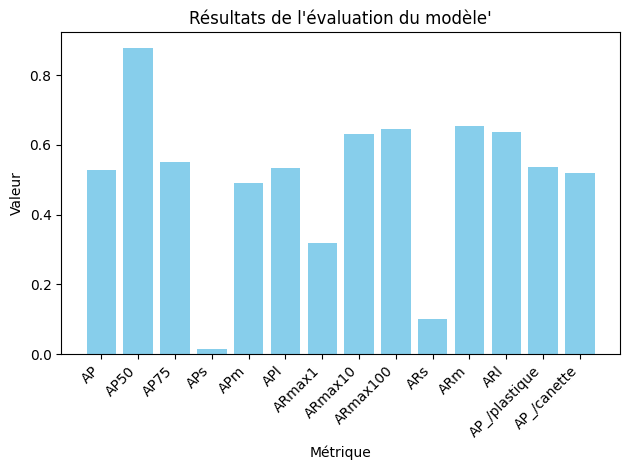

In [8]:
# https://cocodataset.org/#detection-eval
# val_loss, val_accuracy = model.evaluate(val_data)

evaluation = model.evaluate(val_data)

def plotEvaluation(eval, title="Résultats de l\'évaluation du modèle'"):
    import matplotlib.pyplot as plt
    plt.bar(eval.keys(), eval.values(), color='skyblue')
    plt.xlabel('Métrique')
    plt.ylabel('Valeur')
    plt.title(title)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

plotEvaluation(evaluation)

## Export du modèle au format Tensorflow lite

In [9]:
config = QuantizationConfig.for_float16()
model.export(export_dir='bin/', 
             tflite_filename='greengardians.tflite', 
             quantization_config=config)
# model.export(export_dir='bin/', 
#              quantization_config=config,
#              export_format=[ExportFormat.SAVED_MODEL, ExportFormat.LABEL])


2024-04-13 00:38:55.746053: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2024-04-13 00:39:48.362071: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'resample_p7/PartitionedCall' has 1 outputs but the _output_shapes attribute specifies shapes for 3 outputs. Output shapes may be inaccurate.
2024-04-13 00:40:05.596679: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2024-04-13 00:40:05.596733: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2024-04-13 00:40:05.616706: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmp6m2upxmc
2024-04-13 00:40:05.818473: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2024-04-13 00:40:05.818527: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if pre

Estimated count of arithmetic ops: 13.698 G  ops, equivalently 6.849 G  MACs


## Evaluation du modèle entrainé

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


16/16 [==============================] - 7s 359ms/step



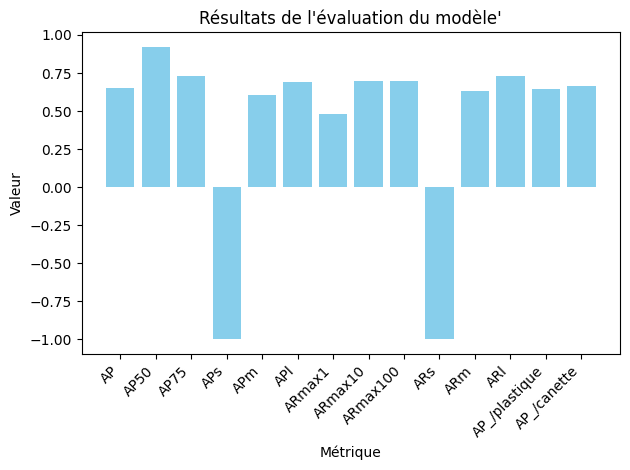

In [10]:
model_path = 'bin/greengardians.tflite'
evaluation_lite = model.evaluate_tflite(model_path, test_data)

plotEvaluation(evaluation_lite)

In [11]:
# NUMBER_OF_TPUS =  2

# !edgetpu_compiler 'bin/greengardians.tflite' --num_segments=$NUMBER_OF_TPUS

## Utilitaires

In [12]:
import cv2

from PIL import Image

# Load the labels into a list
classes = ['???'] * model.model_spec.config.num_classes
label_map = model.model_spec.config.label_map
for label_id, label_name in label_map.as_dict().items():
  classes[label_id-1] = label_name

# classes = {0: "plastique", 1: "canette"}
print('classes', classes)

# Define a list of colors for visualization
COLORS = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8)

def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  resized_img = tf.cast(resized_img, dtype=tf.uint8)
  return resized_img, original_image


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""

  signature_fn = interpreter.get_signature_runner()

  # Feed the input image to the model
  output = signature_fn(images=image)


  # Get all outputs from the model
  count = int(np.squeeze(output['output_0']))
  scores = np.squeeze(output['output_1'])
  classes = np.squeeze(output['output_2'])
  boxes = np.squeeze(output['output_3'])


  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  return results

def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Load the input image and preprocess it
  preprocessed_image, original_image = preprocess_image(
      image_path,
      (input_height, input_width)
    )

  # Run object detection on the input image
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

  print('results', results)

  # Plot the detection results on the input image
  original_image_np = original_image.numpy().astype(np.uint8)
  for obj in results:
    # Convert the object bounding box from relative coordinates to absolute
    # coordinates based on the original image resolution
    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])

    # Find the class index of the current object
    class_id = int(obj['class_id'])

    # Draw the bounding box and label on the image
    color = [int(c) for c in COLORS[class_id]]
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
    # Make adjustments to make the label visible for all objects
    y = ymin - 15 if ymin - 15 > 15 else ymin + 15
    label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
    cv2.putText(original_image_np, label, (xmin, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  # Return the final image
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8

classes ['plastique', 'canette']


## Prediction

In [14]:
# Load the TFLite model
import os, random
from pathlib import Path
model_path = 'bin/greengardians.tflite'

interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# # Run inference and draw detection result on the local copy of the original file
DETECTION_THRESHOLD = 0.5
          
PROJECT_FOLDER = Path(Path.cwd())
image_folder = str(PROJECT_FOLDER) + '/datasets/dataset.voc/test/'
# imageToPredict = 'datasets/dataset.voc/test/IMG_20231025_095509_jpg.rf.c83cb3628dda974ef28a37ce404b9ab7.jpg'
                                                          
l_detection_result_image = []
files = [image_folder +'/'+ f for f in os.listdir(image_folder) if f.endswith('.jpg')]

# imageToPredict = 'datasets/dataset.voc/test/IMG_20231025_095509_jpg.rf.c83cb3628dda974ef28a37ce404b9ab7.jpg'
imageToPredict = random.choice(files)
print(imageToPredict)
detection_result_image = run_odt_and_draw_results(
        imageToPredict,
        interpreter,
        threshold=DETECTION_THRESHOLD
)
# for file in files:
#     detection_result_image = run_odt_and_draw_results(
#         file,
#         interpreter,
#         threshold=DETECTION_THRESHOLD
#     )
#     l_detection_result_image.append(detection_result_image)

/home/charles/web/alyra/villepropre/vp-server/train/datasets/dataset.voc/test//IMG_20231025_095817_jpg.rf.d1d26b546d4d0d3a1138359d3b716933.jpg


ValueError: Cannot set tensor: Got value of type UINT8 but expected type FLOAT32 for input 0, name: serving_default_images:0 

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))
plt.imshow(imageToPredict)
plt.show()
plt.close()
# test_validation_folder = str(PROJECT_FOLDER) + '/datasets/dataset.voc/test_val/'

# # Show all the detection result
# for image in l_detection_result_image:
#     plt.figure(figsize=(5, 5))
#     plt.imshow(image)
#     plt.show()
#     # Save the image in the validation folder    
#     plt.close()